In [818]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [819]:
train_df = pd.read_csv('train.csv') # 8693 rows
test_df = pd.read_csv('test.csv') 
df = pd.concat([train_df, test_df], axis=0)

In [820]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [821]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


In [822]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [823]:
df['Cabin'].fillna('N/N/N', inplace=True)

deck_num_side = df['Cabin'].apply(lambda x: x.split('/'))
df['CabinDeck'] = list(map(lambda x: x[0], deck_num_side))
df['CabinNum'] = list(map(lambda x: x[1], deck_num_side))
df['CabinSide'] = list(map(lambda x: x[2], deck_num_side))
df.drop('Cabin', axis=1, inplace=True)

In [824]:
colfillmode = ['VIP']
colfillnone = ['Destination', 'HomePlanet', 'Name']
colfillmedian = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for col in colfillmode:
    df[col].fillna(df[col].mode()[0], inplace=True)
for col in colfillnone:
    df[col].fillna('None', inplace=True)
for col in colfillmedian:
    df[col].fillna(df[col].median(), inplace=True)

# if no money spent, more likely sleeping. if money spent, no cryo sleep
df['CryoSleep'] = df.apply(lambda row: False if row['RoomService'] > 0 or row['FoodCourt'] > 0 or row['ShoppingMall'] > 0 or row['Spa'] > 0 or row['VRDeck'] > 0 else True, axis=1)


In [825]:
df['Destination'].value_counts()

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
None              274
Name: Destination, dtype: int64

In [826]:
gggg_pp = df['PassengerId'].apply(lambda x: x.split('_')).values
df['GGGG'] = list(map(lambda x: x[0], gggg_pp))
df['PP'] = list(map(lambda x: x[1], gggg_pp))
grouplist = {}
for i in df['GGGG']:
    if i not in grouplist:
        grouplist[i] = 1
    else:
        grouplist[i] += 1
df['GroupCount'] = df['GGGG'].apply(lambda x: grouplist[x])


In [827]:
group_trip = {} # Group Num : [HomePlanet, Destination]
for i, person in df.iterrows():
    pgroup = person['GGGG']
    if pgroup not in group_trip:
        group_trip[pgroup] = [person['HomePlanet'], person['Destination']]
    else:
        if group_trip[pgroup][0] == 'None' and person['HomePlanet'] != 'None':
            group_trip[pgroup][0] = person['HomePlanet']
        if group_trip[pgroup][1] == 'None' and person['Destination'] != 'None':
            group_trip[pgroup][1] = person['Destination']

In [828]:
df['Destination'] = df.apply(lambda row: group_trip[row['GGGG']][1], axis=1)
df['HomePlanet'] = df.apply(lambda row: group_trip[row['GGGG']][0], axis=1)

In [829]:
df['TotalSpent'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

Transform the money ones to log10 scale due to large skew

In [830]:
for col in ['TotalSpent', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    df[col] = np.log10(df[col] + 1)
    df[col+'Above0'] = df[col].apply(lambda x: 1 if x > 0 else 0)
df['PlacesMoneySpent'] = df['RoomServiceAbove0'] + df['FoodCourtAbove0'] + df['ShoppingMallAbove0'] + df['SpaAbove0'] + df['VRDeckAbove0']

In [831]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,GGGG,PP,GroupCount,TotalSpent,TotalSpentAbove0,RoomServiceAbove0,FoodCourtAbove0,ShoppingMallAbove0,SpaAbove0,VRDeckAbove0
0,0001_01,Europa,True,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,...,0001,01,1,0.000000,0,0,0,0,0,0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,2.041393,1.000000,1.414973,2.740363,...,0002,01,1,2.867467,1,1,1,1,1,1
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,1.643453,3.553519,0.000000,3.827111,...,0003,01,2,4.016365,1,1,1,0,1,1
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.000000,3.108565,2.570543,3.522444,...,0003,02,2,3.714078,1,0,1,1,1,1
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,2.482874,1.851258,2.181844,2.752816,...,0004,01,1,3.038223,1,1,1,1,1,1


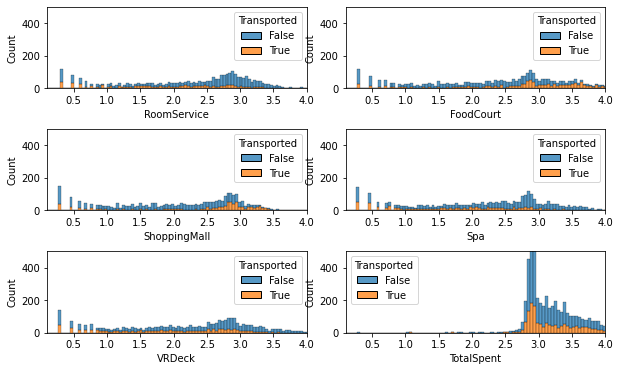

In [832]:
fig = plt.figure(figsize=(10, 6))
moneyplaces = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpent']
for i in range(len(moneyplaces)):
    plt.subplot(3, 2, i+1)
    sns.histplot(x=moneyplaces[i], bins=100, hue='Transported', data=temp, multiple='stack')
    plt.axis([0.1, 4, 0, 500])
plt.subplots_adjust(wspace=0.15, hspace=0.5)

df['SpentALot'] = df['TotalSpent'].apply(lambda x: 1 if x > 2.9 else 0)


Younger people look to have a much higher proportion of being transported

<AxesSubplot:xlabel='Age', ylabel='Count'>

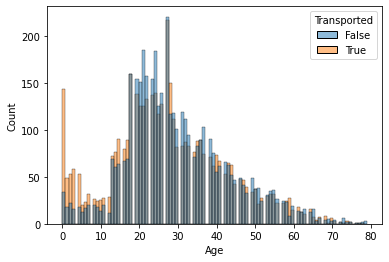

In [833]:
temp = df.iloc[:8693, :]
sns.histplot(x='Age', bins=100, hue='Transported', data=temp)

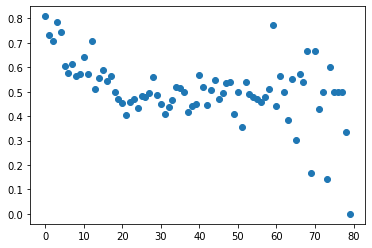

In [834]:
age_transported = {}
for i, person in temp.iterrows():
    if person['Transported']:
        if person['Age'] in age_transported:
            age_transported[person['Age']] += 1
        else:
            age_transported[person['Age']] = 1

valcounts = temp['Age'].value_counts()
for i in valcounts.index:
    if i not in age_transported:
        age_transported[i] = 0
    else:
        age_transported[i] /= valcounts[i]

plt.scatter(age_transported.keys(), age_transported.values())

Looks like specifically < 18 and < 5 are the big differences in transported rates

In [835]:
sorted(age_transported.items(), key=lambda x: x[0])

[(0.0, 0.8089887640449438),
 (1.0, 0.7313432835820896),
 (2.0, 0.7066666666666667),
 (3.0, 0.7866666666666666),
 (4.0, 0.7464788732394366),
 (5.0, 0.6060606060606061),
 (6.0, 0.575),
 (7.0, 0.6153846153846154),
 (8.0, 0.5652173913043478),
 (9.0, 0.5714285714285714),
 (10.0, 0.6410256410256411),
 (11.0, 0.574468085106383),
 (12.0, 0.7073170731707317),
 (13.0, 0.5106382978723404),
 (14.0, 0.5579710144927537),
 (15.0, 0.5870967741935483),
 (16.0, 0.54421768707483),
 (17.0, 0.5632911392405063),
 (18.0, 0.5),
 (19.0, 0.4709897610921502),
 (20.0, 0.4548736462093863),
 (21.0, 0.40514469453376206),
 (22.0, 0.4570446735395189),
 (23.0, 0.4691780821917808),
 (24.0, 0.43209876543209874),
 (25.0, 0.48148148148148145),
 (26.0, 0.47761194029850745),
 (27.0, 0.4954337899543379),
 (28.0, 0.5617977528089888),
 (29.0, 0.48695652173913045),
 (30.0, 0.44808743169398907),
 (31.0, 0.41089108910891087),
 (32.0, 0.4371859296482412),
 (33.0, 0.46629213483146065),
 (34.0, 0.5202702702702703),
 (35.0, 0.51461988

In [836]:
df['Under_5'] = df['Age'].apply(lambda x: 1 if x < 5 else 0)
df['Under_18'] = df['Age'].apply(lambda x: 1 if x < 18 else 0)

In [837]:
df['Trip'] = df['HomePlanet'] + '_' + df['Destination']

In [838]:
df['Trip'] = df['Trip'].apply(lambda x: 'Unknown' if 'None' in x else x)

<AxesSubplot:xlabel='HomePlanet', ylabel='Transported'>

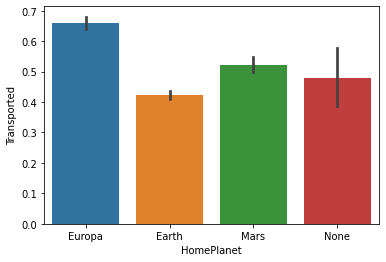

In [839]:
sns.barplot(x='HomePlanet', y='Transported', data=temp)

<AxesSubplot:xlabel='Destination', ylabel='Transported'>

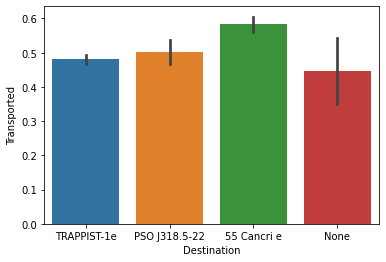

In [840]:
sns.barplot(x='Destination', y='Transported', data=temp)

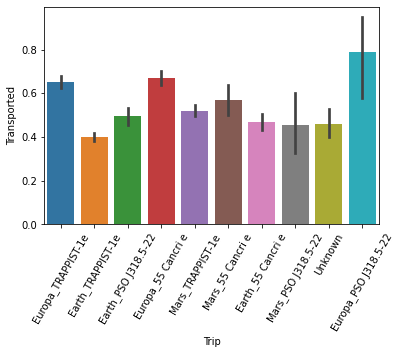

In [841]:
sns.barplot(x='Trip', y='Transported', data = df.iloc[:8693, :])
plt.xticks(rotation=60)
plt.show()

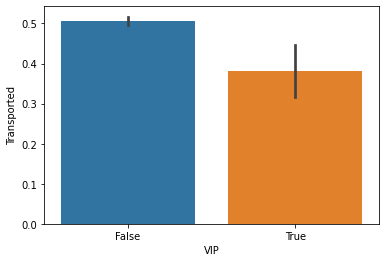

In [842]:
sns.barplot(x='VIP', data=temp, y='Transported')
plt.show()

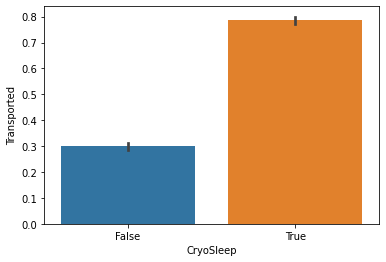

In [843]:
sns.barplot(x='CryoSleep', data=temp, y='Transported')
plt.show()

In [844]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'CabinDeck', 'CabinNum', 'CabinSide', 'GGGG', 'PP',
       'GroupCount', 'TotalSpent', 'TotalSpentAbove0', 'RoomServiceAbove0',
       'FoodCourtAbove0', 'ShoppingMallAbove0', 'SpaAbove0', 'VRDeckAbove0',
       'SpentALot', 'Under_5', 'Under_18', 'Trip'],
      dtype='object')

In [845]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,TotalSpentAbove0,RoomServiceAbove0,FoodCourtAbove0,ShoppingMallAbove0,SpaAbove0,VRDeckAbove0,SpentALot,Under_5,Under_18,Trip
0,0001_01,Europa,True,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,Europa_TRAPPIST-1e
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,2.041393,1.000000,1.414973,2.740363,...,1,1,1,1,1,1,0,0,0,Earth_TRAPPIST-1e
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,1.643453,3.553519,0.000000,3.827111,...,1,1,1,0,1,1,1,0,0,Europa_TRAPPIST-1e
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.000000,3.108565,2.570543,3.522444,...,1,0,1,1,1,1,1,0,0,Europa_TRAPPIST-1e
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,2.482874,1.851258,2.181844,2.752816,...,1,1,1,1,1,1,1,0,1,Earth_TRAPPIST-1e


In [846]:
df.drop(['GGGG', 'PP', 'PassengerId', 'Name', 'CabinNum', 'CabinDeck'], axis=1, inplace=True)

In [847]:
train = df.iloc[:8693, :]
test = df.iloc[8693:, :]
X_train = train.drop(['Transported'], axis=1)
y_train = train['Transported'].astype('int')
X_test = test.drop(['Transported'], axis=1)

In [848]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [849]:
X_train.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'GroupCount', 'TotalSpent', 'TotalSpentAbove0',
       'RoomServiceAbove0', 'FoodCourtAbove0', 'ShoppingMallAbove0',
       'SpaAbove0', 'VRDeckAbove0', 'SpentALot', 'Under_5', 'Under_18',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'HomePlanet_None', 'Destination_55 Cancri e', 'Destination_None',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'CabinSide_N',
       'CabinSide_P', 'CabinSide_S', 'Trip_Earth_55 Cancri e',
       'Trip_Earth_PSO J318.5-22', 'Trip_Earth_TRAPPIST-1e',
       'Trip_Europa_55 Cancri e', 'Trip_Europa_PSO J318.5-22',
       'Trip_Europa_TRAPPIST-1e', 'Trip_Mars_55 Cancri e',
       'Trip_Mars_PSO J318.5-22', 'Trip_Mars_TRAPPIST-1e', 'Trip_Unknown'],
      dtype='object')

In [850]:
clf = RandomForestClassifier()
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(clf, X_train, y_train, cv=kf)
# print(scores.mean())
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [851]:
fimports = list(zip(X_train.columns, clf.feature_importances_))
fimports.sort(key=lambda x: x[1], reverse=True)
for i, j in fimports:
    print(i, j)

Age 0.15861533021696955
TotalSpent 0.12156029904365198
Spa 0.07713389537371856
FoodCourt 0.0765072545715944
VRDeck 0.06678656638207882
RoomService 0.0666738569730242
ShoppingMall 0.06579673548956037
CryoSleep 0.05116730478767217
GroupCount 0.050497785203826175
TotalSpentAbove0 0.0388523506654649
SpentALot 0.02290817822242835
RoomServiceAbove0 0.02077410578507104
HomePlanet_Earth 0.020286243898979647
SpaAbove0 0.018204044148455934
VRDeckAbove0 0.01602327953107869
Trip_Earth_TRAPPIST-1e 0.01250728651215049
HomePlanet_Europa 0.012186949901900536
CabinSide_S 0.01100997024337775
CabinSide_P 0.010492366636772155
FoodCourtAbove0 0.01035750940566233
ShoppingMallAbove0 0.008986729672955641
Under_18 0.007051137956420145
HomePlanet_Mars 0.006442522665406539
Destination_TRAPPIST-1e 0.006000471783882823
Destination_55 Cancri e 0.004878306025899156
Trip_Europa_TRAPPIST-1e 0.004592905465328533
Trip_Earth_55 Cancri e 0.004081841906045995
Trip_Mars_TRAPPIST-1e 0.004067329668335416
Trip_Europa_55 Cancri

In [852]:
clf.feature_importances_

array([0.0511673 , 0.15861533, 0.00250533, 0.06667386, 0.07650725,
       0.06579674, 0.0771339 , 0.06678657, 0.05049779, 0.1215603 ,
       0.03885235, 0.02077411, 0.01035751, 0.00898673, 0.01820404,
       0.01602328, 0.02290818, 0.00244543, 0.00705114, 0.02028624,
       0.01218695, 0.00644252, 0.00179631, 0.00487831, 0.00144009,
       0.00362003, 0.00600047, 0.00261856, 0.01049237, 0.01100997,
       0.00408184, 0.00312025, 0.01250729, 0.00392264, 0.00020283,
       0.00459291, 0.00105842, 0.0006492 , 0.00406733, 0.00217835])

In [853]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Transported': preds.astype('bool')})
output.to_csv('submission.csv', index=False)